In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np
from sklearn import preprocessing
import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs = pd.read_csv(train_logs_path)
else:
    train_logs = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

2023-10-23 22:56:45.944244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 22:56:45.944302: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 22:56:45.944324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 22:56:45.950658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [3]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [4]:
train_logs.describe()

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06
mean,2.067649e+03,7.935603e+05,7.936584e+05,9.808498e+01,1.222964e+03,2.314687e+02
std,1.588284e+03,5.149451e+05,5.149428e+05,2.533985e+02,9.485242e+02,1.759088e+02
min,1.000000e+00,1.060000e+02,2.520000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.520000e+02,3.731842e+05,3.732820e+05,6.600000e+01,4.990000e+02,9.600000e+01
50%,1.726000e+03,7.208860e+05,7.209800e+05,9.300000e+01,1.043000e+03,2.000000e+02
75%,2.926000e+03,1.163042e+06,1.163141e+06,1.220000e+02,1.706000e+03,3.270000e+02
max,1.287600e+04,8.313630e+06,8.313707e+06,4.474700e+05,7.802000e+03,1.326000e+03


## Data Analysis

#### Word Count Analysis
Here we will be looking at the effect of the word count on the outcome.

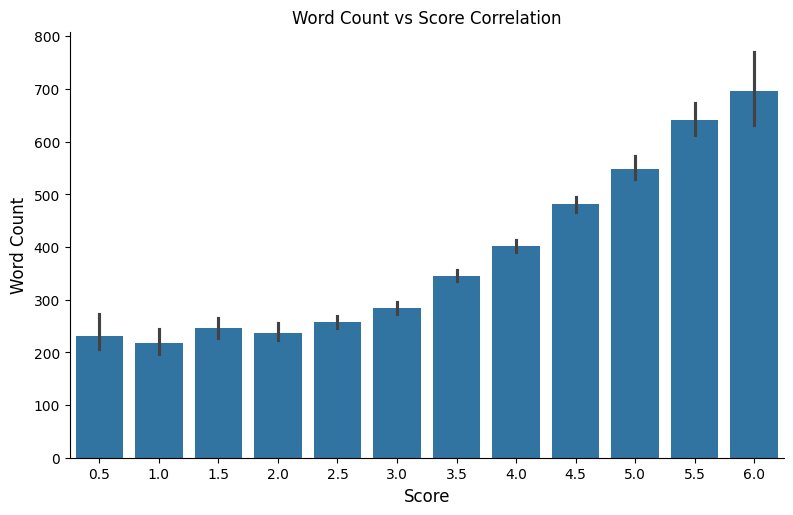

In [5]:
stats = train_logs.groupby("id")["word_count"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

In [6]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,word_count
count,2471.0
mean,390.0
std,172.5
min,35.0
2%,201.0
5%,204.0
25%,255.0
50%,351.0
75%,480.0
95%,724.0


#### Event Analysis

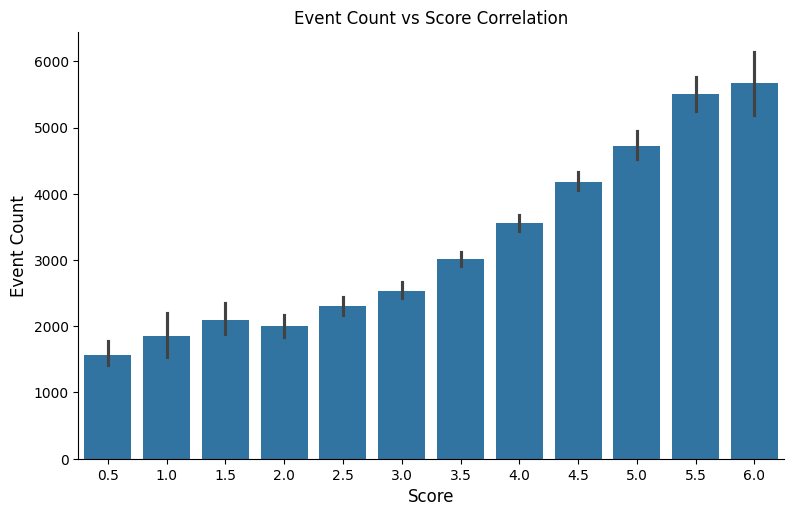

In [7]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

In [8]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,event_id
count,2471.0
mean,3401.8
std,1578.9
min,262.0
2%,1377.8
5%,1524.5
25%,2193.5
50%,3082.0
75%,4301.0
95%,6387.5


In [9]:
train_groups: pd.DataFrame.groupby = train_logs.groupby(["id"])
input_counts = train_groups.activity.count()
print(input_counts)

id
001519c8    2557
0022f953    2454
0042269b    4136
0059420b    1556
0075873a    2531
            ... 
ffb8c745    4739
ffbef7e5    2604
ffccd6fd    3063
ffec5b38    3242
fff05981    3619
Name: activity, Length: 2471, dtype: int64


In [10]:
def FeatureEngineering(df: pd.DataFrame):
    """Computes the feature engineering for training.

    Args:
        df (pd.DataFrame): Input dataframe.

    Returns:
        pd.DataFrame: This will be prepped with everything needed to be inputed as x-values for a dataframe.
    """
    groups = df.groupby("id")
    tails = groups.tail(1)
    insertCount = groups.apply(lambda x: (x["activity"] == "Input").sum())
    removeCount = groups.apply(lambda x: (x["activity"] == "Remove/Cut").sum())
    pasteCount = groups.apply(lambda x: (x["activity"] == "Paste").sum())
    nonproductionCount = groups.apply(lambda x: (x["activity"] == "Nonproduction").sum())
    result = pd.DataFrame(
        {
            "id": df["id"].unique(),
            "num_events": tails["event_id"],
            "word_count": tails["word_count"],
           # "Remove/Cut" : removal_count
        }
    )

    print(result.columns)
    result = pd.merge(result, pd.DataFrame(insertCount), on="id")
    result = pd.merge(result, pd.DataFrame(removeCount), on="id")
    result.columns = result.columns.str.replace('0_x', 'insert_count')
    result.columns = result.columns.str.replace('0_y', 'remove_count')
    
    print(result.columns)
    result = pd.merge(result, pd.DataFrame(pasteCount), on="id")
    result = pd.merge(result, pd.DataFrame(nonproductionCount), on="id")
    result.columns = result.columns.str.replace('0_x', 'paste_count')
    result.columns = result.columns.str.replace('0_y', 'nonproduction_count')

    print(result.columns)
    return result

train_engineered = FeatureEngineering(df=train_logs)
train_engineered.head()

Index(['id', 'num_events', 'word_count'], dtype='object')
Index(['id', 'num_events', 'word_count', 'insert_count', 'remove_count'], dtype='object')
Index(['id', 'num_events', 'word_count', 'insert_count', 'remove_count',
       'paste_count', 'nonproduction_count'],
      dtype='object')


,id,num_events,word_count,insert_count,remove_count,paste_count,nonproduction_count
0,001519c8,2557,255,2010,417,0,120
1,0022f953,2454,320,1938,260,1,254
2,0042269b,4136,404,3515,439,0,175
3,0059420b,1556,206,1304,151,1,99
4,0075873a,2531,252,1942,517,0,72


In [11]:
def NormalizeTrainData(input: pd.DataFrame) -> pd.DataFrame:
    min_max_scaler = preprocessing.MinMaxScaler()
    input["num_events"] = min_max_scaler.fit_transform(input[["num_events"]])
    input["word_count"] = min_max_scaler.fit_transform(input[["word_count"]])
    input["insert_count"] = min_max_scaler.fit_transform(input[["insert_count"]])
    input["remove_count"] = min_max_scaler.fit_transform(input[["remove_count"]])
    input["paste_count"] = min_max_scaler.fit_transform(input[["paste_count"]])
    input["nonproduction_count"] = min_max_scaler.fit_transform(input[["nonproduction_count"]])
    return input

train_data = NormalizeTrainData(train_engineered)

In [12]:
def OneHotEncoding(n: float):
    result = [0]*12
    result[int(n / 0.5) - 1] = 1
    return result

x_train = train_data.sort_values("id").drop("id", axis=1)
raw_scores = train_scores.sort_values("id").drop("id", axis=1)
y_train = np.array([OneHotEncoding(float(y)) for y in raw_scores['score']])

In [13]:
num_train = len(y_train)
x_valid = x_train[:int(num_train*0.2)]
y_valid = y_train[:int(num_train*0.2)]
x_train = x_train[int(num_train*0.2):]
y_train = y_train[int(num_train*0.2):]

In [14]:
model = Sequential([
    Dense(units=8192, activation='relu'),
    Dense(units=2048, activation='relu'),
    Dense(units=512, activation='relu'),
    Dense(units=12, activation="sigmoid")
])

2023-10-23 22:57:07.358049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 22:57:07.365728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 22:57:07.365839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 22:57:07.368389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 22:57:07.368457: I tensorflow/compile

In [15]:
# Create a TensorBoard callback
subfolder = "Log " + datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")
logs = "logs/" + subfolder

callbacks = []
callbacks.append(tf.keras.callbacks.TensorBoard(log_dir = logs, histogram_freq=1))
# callbacks.append(tf.keras.callbacks.ModelCheckpoint(logs+'/ckpt_{epoch}'))
# host_tracer_level=0, python_tracer_level=0, 
options = tf.profiler.experimental.ProfilerOptions(device_tracer_level=1)

tf.profiler.experimental.start(logs, options=options)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    predictions = model(np.array(x_train)).numpy()
    predictions
    tf.nn.softmax(predictions).numpy()
    loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    loss_fn(y_train, predictions).numpy()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, verbose=2, callbacks=callbacks)

tf.profiler.experimental.stop()

# add event files because tensorboard is bugged and can't generate one itself
import os
# os.system("cp logs/events.out.tfevents.1583461681.localhost.profile-empty logs/\'" + subfolder + "\'")
# os.system("cp logs/events.out.tfevents.1583461681.localhost.profile-empty:Zone.Identifier logs/\'" + subfolder + "\'")

%load_ext tensorboard
%tensorboard --logdir=logs

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2023-10-23 22:57:07.886115: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-10-23 22:57:07.886178: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-10-23 22:57:07.886399: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1694] Profiler found 1 GPUs
2023-10-23 22:57:08.275975: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2023-10-23 22:57:11.066527: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


62/62 - 3s - loss: 7.5728 - accuracy: 0.1861 - 3s/epoch - 47ms/step
Epoch 2/10


2023-10-23 22:57:13.026015: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


62/62 - 2s - loss: 6.2181 - accuracy: 0.2008 - 2s/epoch - 28ms/step
Epoch 3/10


2023-10-23 22:57:14.772092: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


62/62 - 2s - loss: 4.1737 - accuracy: 0.1993 - 2s/epoch - 28ms/step
Epoch 4/10


2023-10-23 22:57:16.587148: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


62/62 - 2s - loss: 2.8699 - accuracy: 0.1993 - 2s/epoch - 32ms/step
Epoch 5/10


2023-10-23 22:57:18.587350: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


62/62 - 2s - loss: 2.4888 - accuracy: 0.1993 - 2s/epoch - 31ms/step
Epoch 6/10
62/62 - 2s - loss: 2.3915 - accuracy: 0.1993 - 2s/epoch - 28ms/step
Epoch 7/10
62/62 - 2s - loss: 2.3581 - accuracy: 0.1942 - 2s/epoch - 27ms/step
Epoch 8/10
62/62 - 2s - loss: 2.3416 - accuracy: 0.1993 - 2s/epoch - 27ms/step
Epoch 9/10
62/62 - 2s - loss: 2.3323 - accuracy: 0.2033 - 2s/epoch - 29ms/step
Epoch 10/10
62/62 - 2s - loss: 2.3253 - accuracy: 0.2160 - 2s/epoch - 29ms/step


2023-10-23 22:57:28.355585: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-10-23 22:57:28.360044: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1828] CUPTI activity buffer flushed
2023-10-23 22:57:28.752086: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 63650 callback api events and 63024 activity events. 
2023-10-23 22:57:32.050395: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-10-23 22:57:32.053200: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: logs/Log 10-23-2023 22-57-07/plugins/profile/2023_10_23_22_57_32/BitcoinMiner.xplane.pb


In [16]:
with strategy.scope():
    results = model.evaluate(x_valid, y_valid)
    for a in range(len(results)):
        print(f"{model.metrics_names[a]}: {results[a]:.3f}")

    predictions: np.array = model.predict(x_valid)
    scaled_Pred = []
    for p in predictions:
        max = p.max()
        scaled_Pred.append(np.array([1 if x == max else 0 for x in p]))

16/16 [==============================] - 0s 17ms/step - loss: 2.2878 - accuracy: 0.2166
loss: 2.288
accuracy: 0.217
16/16 [==============================] - 0s 11ms/step


In [17]:
with strategy.scope():
    # Generate the submission
    test_data = FeatureEngineering(test_logs)
    test_data = NormalizeTrainData(test_data)
    predictions = []
    for index, row in test_data.iterrows():
        x_data = [x for x in row[1:]]
        pred = model.predict([x_data])
        max = pred[0].max()
        pred = [1 if x == max else 0 for x in pred[0]]
        result = 0.5
        for index, p in enumerate(pred):
            if p == 1:
                result = 0.5 * index + 0.5
        
        predictions.append((row[0], result)) # (Id, result)
    print(predictions)

Index(['id', 'num_events', 'word_count'], dtype='object')
Index(['id', 'num_events', 'word_count', 'insert_count', 'remove_count'], dtype='object')
Index(['id', 'num_events', 'word_count', 'insert_count', 'remove_count',
       'paste_count', 'nonproduction_count'],
      dtype='object')
1/1 [==============================] - 0s 301ms/step


/tmp/ipykernel_24317/2237452627.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predictions.append((row[0], result)) # (Id, result)


1/1 [==============================] - 0s 154ms/step
[('0000aaaa', 3.5), ('2222bbbb', 4.0), ('4444cccc', 4.0)]


In [18]:
ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]
# ids = [1, 2, 3]
# scores = [0.5, 3.0, 4.5]
sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)